# Import necessary libraries 

In [1]:
#import libraries
import pandas as pd
import string
import re
from gensim.models import Word2Vec
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F
import math
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import numpy as np

## Define the basic building blocks

##  1- Multi-Head Attention

In [2]:
# define class name MultiHeadAttention which is subclass of the nn.Module
class MultiHeadAttention(nn.Module):
    # initial method take two parameter
    # d_model:total dimensional of the input 
    # num_heads: number of the attention heads
    def __init__(self, d_model, num_heads):
        # ensure that  subclass inherit from the superclass(nn.Module)
        super().__init__()
        # take d_model come from method 
        self.d_model = d_model
        # take num_heads come from method  
        self.num_heads = num_heads
        # calculte dimensional of each head
        self.d_k = d_model // num_heads
        # define linear layers 
        # linear layers make(q, k, v,output) have right dimensional to do neural network
        # linear layer to transforme querey with input dimension and output d_model
        self.W_q = nn.Linear(d_model, d_model)
        # linear layer to transforme key with input dimension and output d_model
        self.W_k = nn.Linear(d_model, d_model)
        # layer for to transforme value with input dimension and output d_model
        self.W_v = nn.Linear(d_model, d_model)
        # layer for output of attention with input dimension and output d_model
        self.W_o = nn.Linear(d_model, d_model)
     # define method scaled_dot_product_attention to compute dot-product attention score to q and k and v
    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        # calculate dot product to q and k then divise by root of dimensional of each head
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        # mask used to handle sequence length
        if mask is not None:
            # if mask have empty cell equal zero cover it to -1e9 (very close to zero)
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)
        # using soft max to solve problem of numbers too big or too small and to make sum of each rows in matrix equal one  
        attn_probs = torch.softmax(attn_scores, dim=-1)
        # calculate the weighted sum of values using multiple the attention probability and the values  
        output = torch.matmul(attn_probs, V)
        return output
    
    # define method split_heads it spilt input matrix into small matrices(heads) 
    def split_heads(self, x):
        batch_size, seq_length, d_model = x.size()
        # spilt mateix to number of head and each head have x.size()
        # then transpose matrix 
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)
    
    # define method combine head to take multi-head matrices then combine them back to single matrix 
    def combine_heads(self, x):
        batch_size, num_heads, seq_length, d_k = x.size()
        # do transpose to return matrices to orginal matrix
        # then combine multi-head matrices to single marticx 
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, num_heads * d_k)

    # define forward method 
    def forward(self, Q, K, V, mask=None):
        # split q into multiple heads by using funcation i do and do linear transformation i define before
        Q = self.split_heads(self.W_q(Q))
        # split k into multiple heads by using funcation i do and do linear transformation i define before
        K = self.split_heads(self.W_k(K))
        # split v into multiple heads by using funcation i do and do linear transformation i define before
        V = self.split_heads(self.W_v(V))
        
        # remove d_model dimensionalto make it batch_size, seq_length as data i will enter  
        Q = Q.squeeze(-1)
        # remove d_model dimensionalto make it batch_size, seq_length as data i will enter 
        K = K.squeeze(-1)
        # remove d_model dimensionalto make it batch_size, seq_length as data i will enter 
        V = V.squeeze(-1)
        # calculate scaled dot product unsig calling funcation
        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)
        # combine multi-head attention  by calling funaction and apply a linear transformation i define before 
        output = self.W_o(self.combine_heads(attn_output))
        return output


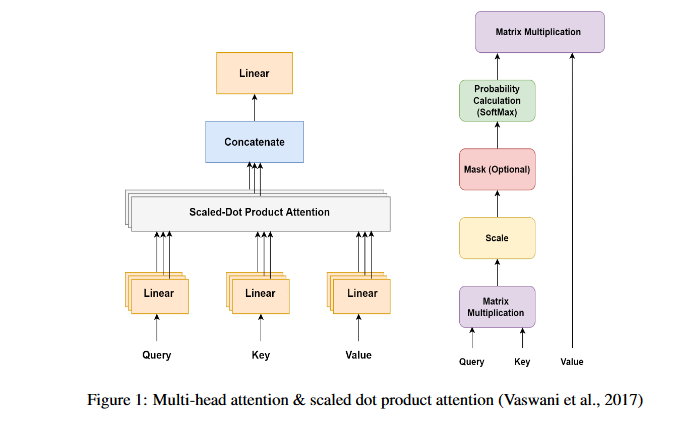

         Goal 
         Multi-Head Attention is used  to capture different relationships between words in a sequence
         Steps
          1- initial total dimensional of the input and  number of heads 
          then apply linear transormation  for querey ane key and value and output 
          2- calculate attention scores between q and k  and scale 
          then use soft max and calculate the weighted sum of value  .
          3. split  input matrix into multiple heads  .
          4. combine the multiple attention head back to single matrix.
          5. forward method return final multi-head attention output by calling funcation i define before.

## 2- Position-wise Feed-Forward Networks

In [3]:
# define class name PositionwiseFeedForward which is subclass of the nn.Module
class PositionwiseFeedForward(nn.Module):
    # initial method take two parameter
    # d_model:total dimensional of the input 
    # d_ff:  dimension of the hidden layer
    def __init__(self, d_model, d_ff, dropout=0.1):
        # ensure that  subclass inherit from the superclass(nn.Module)
        super().__init__()
        # first linear layer transforme  with total dimensional and  dimension of the hidden layer
        self.fc1 = nn.Linear(d_model, d_ff)
        # define ReLU activation function to handle negative values 
        self.relu = nn.ReLU()
        # deopout layer to prevent overfitting 
        self.dropout = nn.Dropout(dropout)
        # second linear layer transforme  with dimension of the hidden and total dimensional    
        self.fc2 = nn.Linear(d_ff, d_model)
    # define fowared funcation to know what happen to data in this layer 
    def forward(self, x):
        # calculate first linear layer by using fc1 to tansor x
        out1 = self.fc1(x)
        # using ReLU activation function to handle result of out1
        out1 = self.relu(out1)
        # add dropout layer 
        out1 = self.dropout(out1)
        # calculate second linear layer by using fc2 and output of ReLU activation function
        out2 = self.fc2(out1)
        return out2

            Goal :
             make model capture complex pattern in the text by regularization and  dropout
             Forward method steps :
             1- calculate first linear layer out1 = x * W1 + b1  where W1 is the weight matrix and baise of first layer
             2- ReLU activation function of out1 = max(0, out1) if out1 is negative will replace with 0
             3- apply dropout
             4- calulate second linear layer out2 = out1 * W2 + b2  where W2 is the weight matrix and baise of scecond layer
             5- then return output

            

## 3- Positional Encoding

In [4]:
# define class name  PositionalEncoding which  is subclass of the nn.Module
class PositionalEncoding(nn.Module):
    # intial method take two parmeter
    # d_model:total dimensional of the input
    # max_seq_length:maximum sequence length     
    def __init__(self, d_model, max_seq_length):
        # ensure that  subclass inherit from the superclass(nn.Module)
        super().__init__()
        # take d_model come from method
        self.d_model = d_model
        # take max_seq_length from method 
        self.max_seq_length = max_seq_length
        # define object positional_encoding from function _generate_positional_encoding
        self.positional_encoding = self._generate_positional_encoding()
    # define funcation to know how postional encoding do 
    def _generate_positional_encoding(self):
        # create array from 0 to max_seq_length this array will contain values type float 
        # reshape array to be vector coulmn 
        position = torch.arange(0, self.max_seq_length, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, self.d_model, 2, dtype=torch.float32) * -(math.log(10000.0) / self.d_model))
        # create matrix of zeros called dimension of max_seq_length and d_model 
        positional_encoding = torch.zeros(1, self.max_seq_length, self.d_model)
        # even number will mulutible by sin
        positional_encoding[0, :, 0::2] = torch.sin(position * div_term)
        # odd number will be multible by cos
        positional_encoding[0, :, 1::2] = torch.cos(position * div_term)
        return positional_encoding
    # define forward method for addition
    def forward(self, x):
        # add tansor x (word embeding) to  
        positional_encoding = self.positional_encoding[:, :x.size(1), :]
        return x + positional_encoding



                Goal:
                Make the model with information about the position in a sequence
                Steps :
                1- create matrix with zeros values of dimenisnoal sequence length and total input
                2- create vector coulmn of position values that each cell contain position to the word in sequence  
                3- define equation that calculate  sin and cos  
                4- calculate sin and cos to each postion by multible equation(divisor) by vector coulmn
                if postion odd using cos and if even using sin
                5- save result matrix in buffer becuase it  not change it has information of order to each word in sequence 
                6- add this martrix to the word embedding to each word  
                   

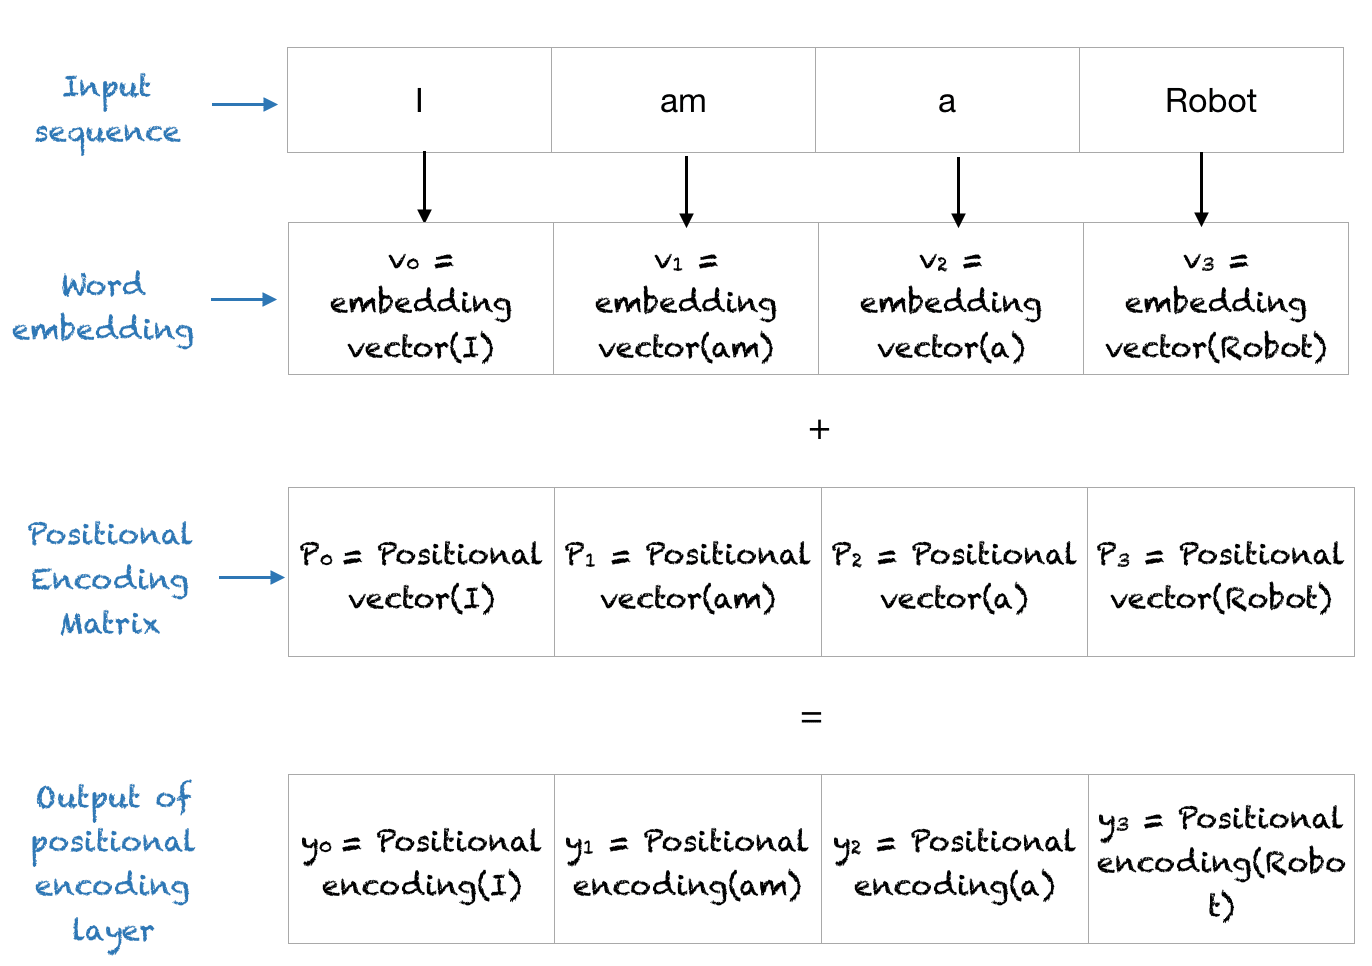

## 4- Build the Encoder Layer

In [5]:
# define class EncoderLayer which is subclass of nn.module  
class EncoderLayer(nn.Module):
    # define method take parmeter which i define in before funcation
    def __init__(self, d_model, num_heads, d_ff, max_seq_length, dropout=0.1):
        # ensure that  subclass inherit from the superclass(nn.Module)
        super().__init__()
        # create first liner layer  for normalization of d_model dimensional
        self.norm1 = nn.LayerNorm(d_model)
        # create second liner layer  for normalization of d_model dimensional
        self.norm2 = nn.LayerNorm(d_model)
        # create object of  PositionalEncoding funcation 
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)
        # create object of MultiHeadAttention funcation
        self.multihead_attention = MultiHeadAttention(d_model, num_heads)
        # careate object of PositionwiseFeedForward funcation
        self.feedforward = PositionwiseFeedForward(d_model, d_ff, dropout)
        # add dropout to prevent overfitting
        self.dropout = nn.Dropout(dropout)
    # define forward to do encoder layer process
    def forward(self, x, mask=None):
        # add dimensional to tansor because data is 2d
        x = x.unsqueeze(1)  
        #  first  add postional encoding to input word embeding tansor
        x = self.positional_encoding(x)
        # remove the addation dimensional
        x = x.squeeze(1) 
        # second  do multi-head attentaion to spilt input matrix to multi heads and combine result 
        # (multihead_attention(x, x, x, mask) is mean (q ,k,v,mask ) than apply result in first normal layer 
        residual = x
        #  third i will do postional wise feed forward to capture complex pattern 
        #  then apply result to second normal layer
        x = self.norm1(x + self.dropout(self.multihead_attention(x, x, x, mask)))
        x = self.norm2(x + self.dropout(self.feedforward(x)))
        return x


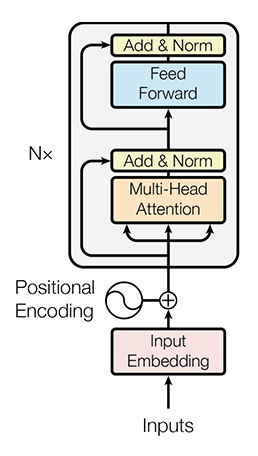
                  

                  Goal:
                  tranfsorm input data to be more meaningful to use it in classification
                  steps :
                  1- create object from classes i created to can use it
                  2- create normalization layers
                  3- add postional encodeing to input word embeding 
                  4- apply multi-head attentaion 
                  5- apply postional wise feed forward

## 5- Decoder layer

In [6]:
# define class DecoderLayer  which is subclass of nn.module  
class DecoderLayer(nn.Module):
    # define method take parmeter which i define in before funcation
    def __init__(self, d_model, num_heads, d_ff, max_seq_length, num_classes, dropout=0.1):
        # ensure that  subclass inherit from the superclass(nn.Module)
        super().__init__()
        # create fisrt liner layer  for normalization of d_model dimensional
        self.norm1 = nn.LayerNorm(d_model)
        # create second liner layer  for normalization of d_model dimensional
        self.norm2 = nn.LayerNorm(d_model)
        # create object of PositionalEncoding class
        # create third liner layer  for normalization of d_model dimensional
        self.norm3 = nn.LayerNorm(d_model)
        # create object of PositionalEncoding class
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)
        # create self attention object of MultiHeadAttention class
        # self attention use masked self-attention to ensure future depend on previous woed
        self.self_attention = MultiHeadAttention(d_model, num_heads)
        # create encoder decoder object of MultiHeadAttention class
        # encoder decoder use to link between encoder output and decoder
        # make drcoder have information about orginal words
        self.encoder_attention = MultiHeadAttention(d_model, num_heads)
        # create object of PositionwiseFeedForward class
        self.feedforward = PositionwiseFeedForward(d_model, d_ff, dropout)
        # add dropout layer to prevent overfitting
        self.dropout = nn.Dropout(dropout)
        # add linear layer for classification
        self.classification_layer = nn.Linear(d_model, num_classes)
    # define forward to do decoder layer process
    def forward(self, x, encoder_output, src_mask=None, tgt_mask=None):
        x = x.unsqueeze(1)  
        # first  add postional encoding to input word embeding tansor
        x = self.positional_encoding(x)
        x = x.squeeze(1)  
        # second  do self_attention  
        # (self_attention(x, x, x, mask) is mean (q ,k,v,mask ) then add to(postional encoding + word embeding)
        self_attention_output = self.norm1(x + self.dropout(self.self_attention(x, x, x, tgt_mask)))
        # link between encoder output and self_attention_output 
        encoder_attention_output = self.norm2(self_attention_output + self.dropout(self.encoder_attention(self_attention_output, encoder_output, encoder_output, src_mask)))
        # result of multihed attentaion enter to feedforward layer
        ff_output = self.norm3(encoder_attention_output + self.dropout(self.feedforward(encoder_attention_output)))
        #  Apply the classification linear layer to the final output
        # class_logits is contain how input belong to differnt class(raw scores)
        class_logits = self.classification_layer(ff_output)
        # apply softmax to calculate probabily from raw scores
        class_probs = torch.softmax(class_logits, dim=-1)
        
        return class_logits, class_probs


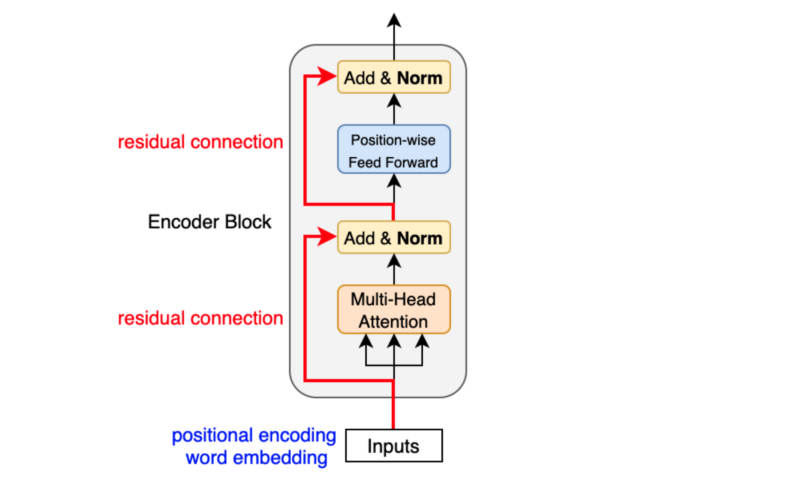

                        Goal :
                        predict next word (output) based on previous words and information come from the encoder
                        Steps :
                        1- using output of encoder layer(information about word) and enter it to decoder layer
                        2- add positional encoding matrix and output of encoder
                        3- apply multi-haed(self attention) first calculate attention scores (q and k) then scale then using   
                          mask and soft max then calculate weighted sum of values (self attention output)
                        4- add self attention output to input(output of encoder) (residual) and normaliztion
                        5- apply multi-head (encoder decoder) same process of step 3 but using q from self attention output
                        6- add output of multi-head (encoder decoder) to multi-haed(self attention) output and normaliztion                               (residual)
                        6- apply position-wise feedforward to output of multi-head (encoder decoder)
                        7- add position-wise feedforward output and multi-head (encoder decoder)(residual) and normaliztion
                        8- enter final output to a linear layer using for classification 
                        9- using soft max to calculate probabilty to each class 
                     
                        
                        

## 6- Combine between DecoderLayer and Encoder Layer to create the complete Transformer 

In [7]:
# define class DecoderLayer  which is subclass of nn.module  
class Transform(nn.Module):
    # define method prameter
    def __init__(self, d_model, num_heads, num_layers, d_ff, max_seq_length, num_classes, dropout=0.1):
        # ensure that  subclass inherit from the superclass(nn.Module)
        super().__init__()
        # create object of positional encoding class to use it 
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)
        # create encoder layers and save it in ModuleList
        self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, max_seq_length, dropout) for _ in range(num_layers)])
        # create object from decoder layer
        self.decoder_layer = DecoderLayer(d_model, num_heads, d_ff, max_seq_length, num_classes, dropout)
        # add linear layer of input dimension and output dimension
        self.fc = nn.Linear(d_model, num_classes)
        # add dropout to prevent overfitting
        self.dropout = nn.Dropout(dropout)
    # define forward method to combine between them 
    def forward(self, x, mask=None):
        
        x = x.unsqueeze(2)  
        # first enter input words tansor to positional encoding and add to embeding then add dropout layer 
        embedded = self.dropout(self.positional_encoding(x))
        embedded = embedded.squeeze(2) 
        # list to store class logits from each step
        class_logits_list = []
        #  using mask to handle small numbers it cover it ti zero
        if mask is not None:
            embedded = embedded.masked_fill(~mask.unsqueeze(-1), 0.0)
            
        enc_output = embedded
         # enter embedded into for loop of number of layers
        # and result of one loop enter as input in next loop to predict class successfully
        for enc_layer in self.encoder_layers:
            enc_output = enc_layer(enc_output, mask)
        # enter the encoder output  decoder layer
        # the decoder layer will calculate probabily from class_logits
        class_logits, _ = self.decoder_layer(enc_output, enc_output, mask)
        # add class logits to the list
        class_logits_list.append(class_logits)
        # sum the logits from all layers
        sum_class_logits = torch.sum(torch.stack(class_logits_list), dim=0)
        # calculate class probabilities
        class_probs = torch.softmax(sum_class_logits, dim=-1)
        return class_probs


                    Goal 
                    combine between encoder layer and decoder layer to make transform by calling encoder and decoder layers

## Prepare  data

In [8]:
# read data set
data = pd.read_csv(r"C:\Users\sony\Desktop\data\train.csv")
data

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


In [9]:
# check if data have missing values or not
data.isnull().sum()


id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

          data haven't missing values

In [10]:
# define clean_date funcation 
def clean_data (input_text):
    # remove characters between text 
    processed_text = re.sub(r'\b\w+\w{2,}\w+\b', '', input_text)
    # remove duplicate in words
    processed_text = re.sub(r'(.)\1+', r'\1', processed_text)
    # make words in lower case
    processed_text = processed_text.lower()
    # remove punctuation marks 
    processed_text = re.sub(f"[{re.escape(string.punctuation)}]", "", processed_text)
    # remove new line shape 
    processed_text = processed_text.replace('\n', ' ')
    # remove extra white space 
    processed_text = re.sub(r'\s+', ' ', processed_text).strip()
    # remove numbers
    processed_text = re.sub(r'\d+', '', processed_text)
    # tokenize the text (spilt data into words using white space)
    tokens = word_tokenize(processed_text)
    # stop wods englis 
    stop_words = set(stopwords.words('english'))
    # remove stop words by compare data words (tokenize) by stop words and delet common words
    filtered_tokens = [word for word in tokens if word not in stop_words]
    # The Snowball stemmer is used for word stemming   
    stemmer = SnowballStemmer("english")
    # do stemming (return word to its root) to words after i remove stop words 
    stemmed_tokens = [stemmer.stem(word) for word in filtered_tokens]
    # clean words which have one letter 
    cleaned_tokens = [word for word in stemmed_tokens if re.match(r'^[a-zA-Z0-9]*$', word)]
    # remove duplicate words 
    unique_tokens = list(set(cleaned_tokens))
    return  unique_tokens


                    funcation cleaned data :
                    goal delet are numbers and duplicated words and punctuation marks and shape of new line
                    tokenize data mean spilt data into words by ,
                    stemming is return all words to it root 
                    remove special charachter and words have one letter 
                    remove duplicate words after do steaming 

In [11]:
data['cleaned_comments'] = data['comment_text'].apply(clean_data)


In [12]:
data

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,cleaned_comments
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,"[fan, dont, new, fac, gas, im]"
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,"[utc, daw, im]"
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,"[man, hey, war, im, guy]"
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,"[etc, may, al, cant, eg, ie, noon, let]"
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,[sir]
...,...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0,[cant]
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0,[put]
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0,[um]
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0,[put]


In [13]:
# get length of list which have max size
max_length = max(len(comment) for comment in data['cleaned_comments'])
max_length


85

In [14]:
data.dtypes

id                  object
comment_text        object
toxic                int64
severe_toxic         int64
obscene              int64
threat               int64
insult               int64
identity_hate        int64
cleaned_comments    object
dtype: object

## Word Embeding


In [15]:
# define funcation to train word2vec
def Model (sentences, vector_size, window, min_count, sg):

    model = Word2Vec(sentences=sentences, vector_size=vector_size, window=window, min_count=min_count, sg=sg)
    
    return model
# define funcation to do word embeding to all data
def Word_Embeddings(text_list, model):
   # empty list 
    embeddings = []
    # for loop to all data which i need do word emceding 
    for text in text_list:
        # using model.wv to search for each token  
        valid_tokens = [token for token in text if token in model.wv]
        if valid_tokens:
            # if found token calculate mean of this word
            text_embedding = model.wv[valid_tokens].mean(axis=0)
            # and add it to list
            embeddings.append(text_embedding)
        else:
            # if not make list of zeros to not have empty list
            embeddings.append(np.zeros(model.vector_size))
    return embeddings


In [16]:
# calling funcations to do word embeding
embeding= Model(data['cleaned_comments'].tolist(), vector_size=200, window=5, min_count=5, sg=0)
data['word_embedding'] = Word_Embeddings(data['cleaned_comments'],embeding)


In [17]:
data

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,cleaned_comments,word_embedding
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,"[fan, dont, new, fac, gas, im]","[-0.042550024, -0.023216212, -0.09892854, 0.19..."
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,"[utc, daw, im]","[-0.09261153, -0.021924868, -0.11768818, 0.604..."
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,"[man, hey, war, im, guy]","[0.0077352137, -0.13725045, -0.110402845, 0.34..."
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,"[etc, may, al, cant, eg, ie, noon, let]","[0.056904517, 0.00797224, 0.0052435547, 0.1671..."
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,[sir],"[-0.05275039, 0.05392863, 0.04342239, 0.140796..."
...,...,...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0,[cant],"[-0.267121, -0.06221318, -0.062962584, 0.16607..."
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0,[put],"[0.42574444, -0.23274356, -0.30755755, 0.47015..."
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0,[um],"[0.08428022, -0.06832627, -0.039814163, 0.2711..."
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0,[put],"[0.42574444, -0.23274356, -0.30755755, 0.47015..."


                       Now i cleaned data and cover it into numberes

## Spilting Data

In [18]:
# funcation to spilt data into train and test 
def split_data(data, features_column, labels_columns, test_size, random_state):
    # learn coulmn
    X = data[features_column]
    # target coulmns
    y = data[labels_columns]    

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    return X_train, X_test, y_train, y_test



In [19]:
# calling funcation to spilt data 80% for trainig and 42 random state
X_train, X_test, y_train, y_test = split_data(data, 'word_embedding', ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'], 0.2, 42)


In [20]:
print ('X_train',X_train.shape)
print ('X_test',X_test.shape)
print ('y_train',y_train.shape)
print ('y_test',y_test.shape)


X_train (127656,)
X_test (31915,)
y_train (127656, 6)
y_test (31915, 6)


In [21]:
# funcation to craete data loader
def preprocess_data(X, y, batch_size, sequence_length=None, num_classes=6, shuffle=True, is_train=True):
    # convert data into  numpy 
    X_numpy = np.array(X.tolist(), dtype=np.float32)
    # get length from x shape
    if sequence_length is None:
        sequence_length = X_numpy.shape[1]
    # convert numpy to pytorch 
    X_tensor = torch.tensor(X_numpy, dtype=torch.float32)
    y_tensor = torch.tensor(y.values, dtype=torch.float32).view(-1, num_classes)
    # for the  traing data
    if is_train:
        # create dataset from tansor and data loader training
        dataset = TensorDataset(X_tensor, y_tensor)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
        return dataloader
    else:
        # create data set from tansor and data loader test
        dataset = TensorDataset(X_tensor, y_tensor)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
        return dataloader, sequence_length


                   preprocess_data goal :
                   1- turn data into numpy to can do next step
                   2- turn nupy into tensor to because it  suitable for efficient numerical computations
                   3- turn tansor to data loader which design to work with tansor and making it easier to feed  data in deep                        learning model

In [23]:
batch_size = 64
sequence_length=200
# calling  funcation and create dataloader traing 
train_dataloader = preprocess_data(X_train, y_train, batch_size=batch_size, sequence_length=sequence_length, shuffle=True, is_train=True)
# calling  funcation and create dataloader test with batch and number of classes 
test_dataloader, test_sequence_length = preprocess_data(X_test, y_test, batch_size=batch_size, sequence_length=sequence_length, shuffle=False, is_train=False)



In [24]:
# shape of data in the train_dataloader
for batch in train_dataloader:
    inputs, labels = batch
    print("Train - Batch Shape:")
    print("Inputs:", inputs.shape) 
    print("Labels:", labels.shape) 
    break

# shape of data in the test_dataloader
for batch in test_dataloader:
    inputs, labels = batch
    print("Test Data - Batch Shape:")
    print("Inputs:", inputs.shape)  
    print("Labels:", labels.shape)  
    break

Train - Batch Shape:
Inputs: torch.Size([64, 200])
Labels: torch.Size([64, 6])
Test Data - Batch Shape:
Inputs: torch.Size([64, 200])
Labels: torch.Size([64, 6])


## Train the model

In [ ]:
# define the model by calling funcation and define parameters
model = Transform(d_model=200, num_heads=8, num_layers=6, d_ff=2048, max_seq_length=200, num_classes=6, dropout=0.1)
# define loss function to optimaze  
criterion = nn.CrossEntropyLoss()
# define optimizer to multi classification with learning rate 0.001
optimizer = optim.Adam(model.parameters(), lr=0.001)

# define train funcation with model and train data and loss funcation and optimizer
def train(model, train_dataloader, criterion, optimizer):
    model.train()
    # for batch in train data for trainig all data
    for batch in train_dataloader:
        # get input data and label
        inputs, labels = batch  
        # remover gredent descent to calculate it agin
        optimizer.zero_grad()
        # conve label to the long data type
        labels = labels.long()
        # do model 
        outputs = model(inputs)
        # calculate loss funcation
        loss = criterion(outputs, labels)
        # calculate new gradient 
        loss.backward()
        # using optimizer to optimize the result 
        optimizer.step()
        print("it is train")

# define number of epoch  need to be 32 to get  more accuarcy but i define small number beacuase it take more 24 hours     
num_epochs = 1

# calling the model funcation with number of epoch 
for epoch in range(num_epochs):
    train(model, train_dataloader, criterion, optimizer)
    
# define evaluate function 
def evaluate(model, test_loader):
    model.eval()
    # empty list to store label from data 
    all_labels = []
    # empty list to store predict label
    all_preds = []
    # loop to all data in test loader
    for batch in test_loader:
        # get input data and label
        inputs, labels = batch
        # convert label to the long data type
        labels = labels.long()
        # do model
        outputs = model(inputs)
        # get the class which have max highest probability
        _, preds = torch.max(outputs, dim=1)
        # store true labels in empty list i define 
        all_labels.extend(labels.cpu().numpy())
        # store predict label in empty list i define 
        all_preds.extend(preds.cpu().numpy())
        print("it is evualte")
    return all_labels, all_preds

# calling evaluate funcation to evualte the model on the test data in test loader
test_all_labels, test_all_preds = evaluate(model, test_dataloader) 
# calculate accuracy between acuatal data labels and prediction labels
test_accuracy = accuracy_score(test_all_labels, test_all_preds) 
# calculate classification report to know how many predict true and how many false 
test_report = classification_report(test_all_labels, test_all_preds, target_names=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'])

print(f"Test Accuracy - {test_accuracy}")
print(f"Test Classification Report:\n{test_report}\n")

# save the train model in my device
torch.save(model.state_dict(), 'C:\\Users\\sony\\Desktop\\trained_model.pth')




it is train
it is train
it is train
it is train
it is train
it is train
it is train
it is train
it is train
it is train
it is train
it is train
it is train
it is train
it is train
it is train
it is train
it is train
it is train
it is train
it is train
it is train
it is train
it is train
it is train
it is train
it is train
it is train
it is train
it is train
it is train
it is train
it is train
it is train
it is train
it is train
it is train
it is train
it is train
it is train
it is train
it is train
it is train
it is train
it is train
it is train
it is train
it is train
it is train
it is train
it is train
it is train
it is train
it is train
it is train
it is train
it is train
it is train
it is train
it is train
it is train
it is train
it is train
it is train
it is train
it is train
it is train
it is train
it is train
it is train
it is train
it is train
it is train
it is train
it is train
it is train
it is train
it is train
it is train
it is train
it is train
it is train
it is train
it i

In [ ]:
## the model is running and no get result it runing  23 hours and The electricity stopped when epoche 32
## i change number of epoch to be one but also take time more i have and no result 
## but isnt print  errors